In [42]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [43]:
dog_dir = './train/dogs'

# List all files in the directory
all_files = os.listdir(dog_dir)

# Create a list of images by reading each file in the directory
dog_images = [cv2.resize(cv2.imread(os.path.join(dog_dir, file)), (275, 275))
              for file in all_files if file.endswith(('.png', '.jpg', '.jpeg'))]

In [44]:
cat_dir = './train/cats'

# List all files in the directory
all_files = os.listdir(cat_dir)

cat_images = [cv2.resize(cv2.imread(os.path.join(cat_dir, file)), (275, 275))
              for file in all_files if file.endswith(('.png', '.jpg', '.jpeg'))]

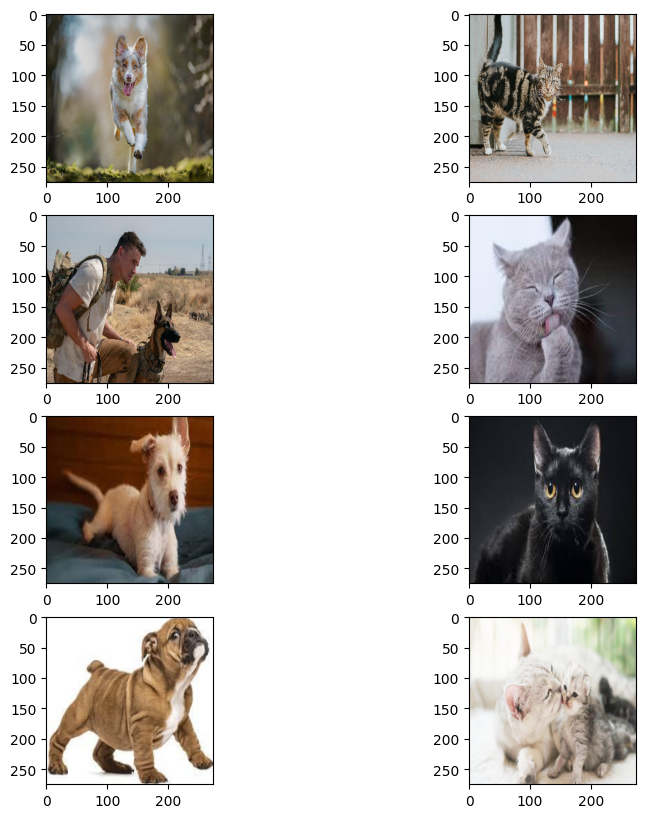

In [45]:
um_images = 8  # Limit to 8 images if more than 8 available
fig, ax = plt.subplots(4, 2, figsize=(10, 10))

for i, img in enumerate(dog_images[:4]):  # Display only first 4 dog images
    ax[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

for i, img in enumerate(cat_images[:4]):  # Display only first 4 cat images
    ax[i, 1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()

In [46]:
base_dir = './train'

# Parameters
image_size = (275, 275)
batch_size = 32
seed = 1

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    image_size=image_size,
    seed=seed,
    batch_size=batch_size
)

# Shuffle the dataset
dataset = dataset.shuffle(len(dataset), seed=seed)

# Calculate the lengths of the splits
total_length = len(dataset)
train_length = int(total_length * 0.8)  # 80% for training
cv_length = int(total_length * 0.1)  # 10% for cross-validation
test_length = total_length - train_length - cv_length  # Remaining for testing

# Manually split the dataset
train_dataset = dataset.take(train_length)
cv_dataset = dataset.skip(train_length).take(cv_length)
test_dataset = dataset.skip(train_length + cv_length)

# Function to extract features and labels from a dataset
def extract_features_labels(dataset):
    features = []
    labels = []
    for images, labels_batch in dataset:
        features.append(images.numpy())
        labels.append(labels_batch.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features and labels for each set
x_train, y_train = extract_features_labels(train_dataset)
x_cv, y_cv = extract_features_labels(cv_dataset)
x_test, y_test = extract_features_labels(test_dataset)

# Print the shapes of the extracted features and labels to verify
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_cv shape:", x_cv.shape)
print("y_cv shape:", y_cv.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# Optional: Check class distribution in each set
print("\nUnique classes in Train Set:", np.unique(y_train))
print("Unique classes in CV Set:", np.unique(y_cv))
print("Unique classes in Test Set:", np.unique(y_test))

Found 557 files belonging to 2 classes.
x_train shape: (429, 275, 275, 3)
y_train shape: (429,)
x_cv shape: (32, 275, 275, 3)
y_cv shape: (32,)
x_test shape: (96, 275, 275, 3)
y_test shape: (96,)

Unique classes in Train Set: [0 1]
Unique classes in CV Set: [0 1]
Unique classes in Test Set: [0 1]


In [47]:
input_size=(275,275,3)

model=Sequential([
    Flatten(input_shape=input_size),
    Dense(units=275,activation='relu',name='layer_1',kernel_regularizer=l2(0.1)),
    Dense(units=168,activation='relu',name='layer_2',kernel_regularizer=l2(0.1)),
    Dense(units=84,activation='relu',name='layer_3',kernel_regularizer=l2(0.1)),
    Dense(units=42,activation='relu',name='layer_4',kernel_regularizer=l2(0.1)),
    Dense(units=21,activation='relu',name='laye_5',kernel_regularizer=l2(0.1)),
    Dense(units=1,activation='linear',name='layer_6',kernel_regularizer=l2(0.1))
],name='model_1')

model.summary()

c:\Users\adith\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 226875)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 275)            │    62,390,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 168)            │        46,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 84)             │        14,196 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 42)             │         3,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ laye_5 (Dense)                  │ (None, 21)             │           903 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_6 (Dense)                 │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,455,959 (238.25 MB)

 Trainable params: 62,455,959 (238.25 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model.compile(loss=BinaryCrossentropy(from_logits=True),
              optimizer=Adam(8e-3))

history=model.fit(x_train,y_train,epochs=20)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 802ms/step - loss: 44732.3594
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 802ms/step - loss: 17878.8418
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 802ms/step - loss: 7216.8862
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 807ms/step - loss: 5403.4497
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 802ms/step - loss: 3462.1321
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 801ms/step - loss: 2406.8271
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 805ms/step - loss: 1875.9153
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 804ms/step - loss: 1293.5820
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 801ms/step - loss: 904.9906
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 800ms/step - loss: 676.6370
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 808ms/step - loss: 490.4749
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 804ms/step - loss: 373.7143
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 807ms/step - loss: 277.6390
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 810ms/step - loss: 207.8955
Epoch

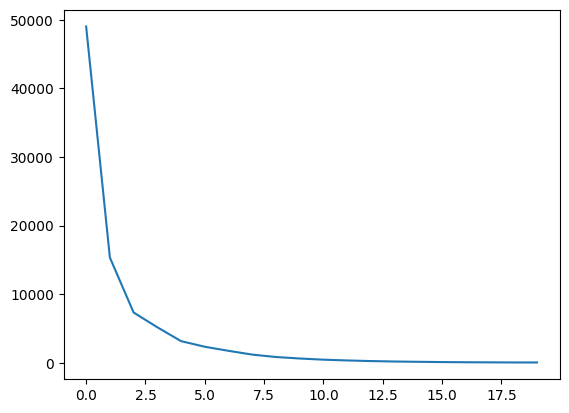

In [49]:
plt.plot(history.history['loss'], label='Training Loss')

In [50]:
logits=model.predict(x_train)
yhat=tf.nn.sigmoid(logits)
yhat=np.where(yhat >=0.5,1,0)
J_train=np.mean(yhat!=y_train)
J_train

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


0.48717948717948717

In [51]:
logits=model.predict(x_cv)
yhat=tf.nn.sigmoid(logits)
yhat=np.where(yhat >=0.5,1,0)
J_cv=np.mean(yhat!=y_cv)
J_cv

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


0.46875

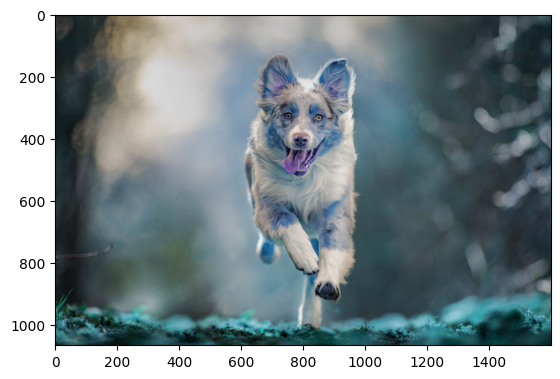

In [58]:
# Read the image using OpenCV
image = cv2.imread('./train/dogs/dog_0.jpg')

# Display the image using Matplotlib
plt.imshow(image)
plt.show()
image_resize=cv2.resize(image,(275,275))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Dog


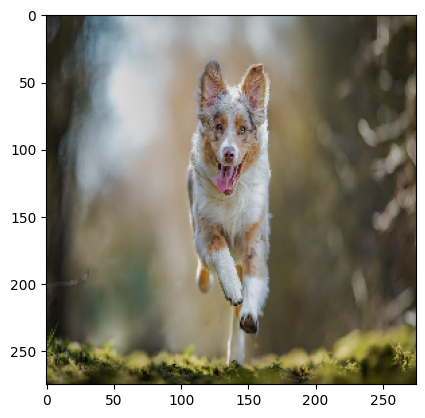

In [64]:
from keras.preprocessing import image 
  
#Input image 
test_image = image.load_img('./train/dogs/dog_0.jpg',target_size=(275,275)) 
  
#For show image 
plt.imshow(test_image) 
test_image = image.img_to_array(test_image) 
test_image = np.expand_dims(test_image,axis=0) 
  
# Result array 
result = model.predict(test_image) 
  
#Mapping result array with the main name list 
i=0
if(tf.nn.sigmoid(result)>=0.5): 
  print("Dog") 
else: 
  print("Cat")